# P300 Rejection Map and Target Matrix Computation Script

This script performs two primary tasks:
1. Computes a target presence matrix that retains the left/right order from the input target array.
2. Computes and plots a rejection map for the P300 dataset based on epochs flagged as “bad” (where the amplitude range exceeds a specified threshold).

*Note: The target matrix computation retains the left and right order in the third dimension. There is a comment suggesting that it might be best to use the original arrays `y` and `z` rather than log the cued side within `y_matrix` if further differentiation is needed.*

---

## Function Description: `compute_target_matrix`

**Purpose:**  
Calculates a target presence matrix by explicitly separating cued and uncued sides. The function uses:
- **`y`**: an array of cued side labels (shape: *(n_trials,)*).
- **`z`**: an array indicating target presence (shape: *(n_trials, n_epochs, 2)*).

**Process:**  
For each trial:
- It determines the cued side (from `y`) and infers the uncued side as the opposite.
- It then checks, for each epoch, whether the target is present on the cued side (first entry) and on the uncued side (second entry).
- The resulting target matrix, `y_matrix`, has shape *(n_trials, n_epochs, 2)* where the first column represents the cued side and the second column the uncued side.

**Return:**
- **`y_matrix`**: A matrix indicating target presence per trial and epoch, with dimensions *(80, 80, 2)*.

---

## Rejection Map Computation and Visualization

### Overview

The script performs the following steps for each subject in a predefined subject list:

1. **Data Loading:**
   - It loads the preprocessed P300 data (including the EEG data `X`, cue labels `y`, target information `z`, and the sampling frequency `fs`) from a `.npz` file.
   - The file is assumed to be located within a derivatives directory specific to the P300 modality.

2. **Compute Target Matrix and Epoch Extraction:**
   - The target matrix is computed using `compute_target_matrix(y, z)`.
   - Epochs are extracted from the continuous EEG data by calling the function `extract_epochs`, which also returns indices of “bad” epochs (where the amplitude range exceeds the threshold).

3. **Rejection Matrix Calculation:**
   - The script calculates the percentage of rejected epochs by comparing the number of unique (trial, epoch) indices flagged as bad with the total number of epochs (here, assumed to be 6400).
   - It then reshapes the extracted epochs into a 2D array (flattening trials and epochs) and initializes a rejection matrix of shape *(num_epochs, n_channels)*.
   - For every bad epoch (provided as a tuple of trial, epoch, and channel), the corresponding cell in the rejection matrix is marked as 1.
   - An additional column labeled `"any()"` is added to indicate whether any channel in that epoch was rejected.

4. **Visualization:**
   - A heatmap (rejection map) is generated for each subject using a dynamic grid layout.
   - If a subject is known to have a problematic channel (according to `subjects_channel_reject`), that channel is excluded from the plot.
   - Each subject’s heatmap shows the rejection status across epochs (rows) and channels (columns). The last column summarizes if any channel in the epoch was flagged.
   - The heatmap for each subject includes the subject ID and the percentage of rejected epochs in the title.
   - Finally, the figure is saved as an SVG file.

### Key Variables

- **`subjects`**: List of subject IDs.
- **`picks_hubner`**: List of channel names.
- **`subjects_channel_reject`**: Dictionary mapping subject IDs to channels that should be excluded in plotting.
- **`reject_percentages`**: List that accumulates the rejection percentages per subject.
- **`subject_rejection_matrices`**: Dictionary that stores the rejection matrix for each subject.
- **`raw_dir`**: Directory where the final rejection map figure will be saved.

---


## Rejection Map to find bad channels

In [1]:
import numpy as np
import os
import sys
from os.path import join
import numpy as np
import mne
import matplotlib.pyplot as plt
mne.set_log_level('warning')
wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
from os.path import join
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(experiment_dir, 'derivatives')
preprocessed_dir = join(derivatives_dir, 'preprocessed')
analysis_dir = join(data_dir, "analysis")
raw_dir = join(analysis_dir, 'raw')

### Define epoch extraction

In [2]:
def extract_epochs(X, start_idx=120, end_idx=2520, step_size=30, 
                   start_sample_offset=-24, end_sample_offset=84, 
                   amplitude_threshold=40e-6):
    """
    Function to extract epochs from time-series data for ERP features, 
    baseline-correct each epoch, and identify bad epochs based on amplitude threshold.
    
    Parameters:
    - X: Input data array of shape (n_trials, n_channels, n_samples)
    - start_idx: The starting sample index for the first epoch (default=120)
    - end_idx: The last sample index where the final epoch starts (default=2520)
    - step_size: Step size in samples, corresponding to the sliding window (default=30)
    - start_sample_offset: The offset for the start of the time window (default=-24, corresponds to -200 ms)
    - end_sample_offset: The offset for the end of the time window (default=84, corresponds to 700 ms)
    - amplitude_threshold: Threshold for identifying bad epochs based on amplitude range (default=100)
    
    Returns:
    - output_matrix: A 4D array of extracted and baseline-corrected epochs of shape 
                     (n_trials, n_epochs, n_channels, window_size)
    - bad_epochs_idx: List of indices of bad epochs for each trial and channel 
                      where amplitude range exceeds the threshold.
    """
    # Check input dimensions
    if X.ndim != 3:
        raise ValueError(f"Input X must have 3 dimensions (n_trials, n_channels, n_samples), but got {X.ndim} dimensions.")
    
    n_trials, n_channels, n_samples = X.shape
    window_size = end_sample_offset + np.abs(start_sample_offset)  # 108 samples
    epoch_timestamps = np.arange(start_idx, end_idx, step_size)    # (80,)
    n_epochs = len(epoch_timestamps)
    
    # Initialize the output matrix for the epochs and a list for bad epoch indices
    output_matrix = np.zeros((n_trials, n_epochs, n_channels, window_size))
    bad_epochs_idx = []  # To store (trial, epoch, channel) indices of bad epochs
    
    # Loop over trials, channels, and epochs to extract and baseline-correct the windows
    for i_trial in range(n_trials):
        for i_channel in range(n_channels):
            data = X[i_trial, i_channel, :]

            for i_epoch, t in enumerate(epoch_timestamps):
                epoch_start_idx = t + start_sample_offset  # Start at t - 24 samples (-200 ms)
                epoch_end_idx = t + end_sample_offset      # End at t + 84 samples (700 ms)
                
                # Ensure the window stays within bounds
                if epoch_start_idx >= 0 and epoch_end_idx <= n_samples:
                    epoch_data = data[epoch_start_idx:epoch_end_idx]
                    
                    # Baseline correction
                    baseline_mean = np.mean(epoch_data[:25])
                    epoch_data = epoch_data - baseline_mean
                    
                    # Store the epoch in the output matrix
                    output_matrix[i_trial, i_epoch, i_channel, :] = epoch_data
                    
                    # Check amplitude range after baseline subtraction
                    min_amp, max_amp = np.min(epoch_data), np.max(epoch_data)
                    amplitude_range = max_amp - min_amp
                    
                    # Log bad epochs if amplitude range exceeds threshold
                    if amplitude_range > amplitude_threshold:
                        bad_epochs_idx.append((i_trial, i_epoch, i_channel))
    
    # Return the 4D output matrix and the indices of bad epochs
    return output_matrix, bad_epochs_idx


### Define Target Matrix

In [3]:
def compute_target_matrix(y, z, print_summary=True):
    
    # Change! retain lft, rght order of 3rd dimension.
    # How and where to log cued side if i stick to y_matrix
    # MAybe best to stick with y and z instead 
    """
    Function to compute target presence matrix with cued and uncued sides explicitly separated.

    Parameters:
    - y: Array of cued sides (shape: (80,))
    - z: Array indicating target presence (shape: (80, 80, 2))

    Returns:
    - y_matrix: Matrix indicating if target is present on cued and uncued sides (shape: (80, 80, 2)),
                with the first entry in the last dimension representing the cued side.
    """
    # Initialize arrays for results
    y_matrix = np.zeros((80, 80, 2))  # First entry: cued side, Second entry: uncued side

    # Main loop
    for i_trial in range(80):
        # Get the cued side and uncued side
        cued_side = y[i_trial]
        uncued_side = 1 - cued_side  # The opposite of the cued side (0 -> 1, 1 -> 0)

        # Create boolean arrays indicating if target is present on each side (80,)
        target_present_cued = z[i_trial, :, cued_side] == 1
        target_present_uncued = z[i_trial, :, uncued_side] == 1

        # Populate the target matrix with cued side as the first entry
        y_matrix[i_trial, :, 0] = target_present_cued.astype(int)
        y_matrix[i_trial, :, 1] = target_present_uncued.astype(int)

    return y_matrix


## Prepare Data

In [4]:
# Compute rejection map
# Define the list of subjects and channels
subjects = ["VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih", "VPpdii", "VPpdij",
            "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
            "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix", "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"]
picks_hubner = [
    "F7", "F3", "Fz", "F4", "F8", "FC1", "FC2", "FC5", "FC6", "FCz", "T7", "C3", 
    "Cz", "C4", "T8", "CP1", "CP2", "CP5", "CP6", "CPz",
    "P7", "P3", "Pz", "P4", "P8", "Oz", "O1", "O2"
]

reject_percentages = []
subject_rejection_matrices = {}
task = 'covert'
for subject in subjects:
    # Load the .npz file for the subject
    file_dir = os.path.join(derivatives_dir, 'preprocessed', "p300", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_p300.npz")
    
    npz_data = np.load(file_path)
    X = npz_data['X']
    y = npz_data['y']
    z = npz_data['z']
    fs = npz_data['fs']
    
    # Compute matrices and bad indices
    y_matrix = compute_target_matrix(y, z)
    X_matrix, bad_idx = extract_epochs(X, amplitude_threshold=40e-6)
    
    # Calculate percentage of rejected epochs
    channel_indices = [item[:2] for item in bad_idx]  # Extract trial and epoch indices
    subj_reject = len(sorted(set(channel_indices))) / 6400
    reject_percentages.append(subj_reject)
    
    # Reshape data for matrix creation
    X_matrix = X_matrix.reshape(6400, X_matrix.shape[2], 108)  # 6400 epochs,  channels, 108 time points
    num_epochs = X_matrix.shape[0]
    num_channels = len(picks_hubner)
    # Initialize rejection matrix (epochs x channels)
    rejection_matrix = np.zeros((num_epochs, num_channels), dtype=int)
    
    # Populate the rejection matrix
    for epoch_outer, epoch_inner, channel_idx in bad_idx:
        flattened_epoch_idx = epoch_outer * 80 + epoch_inner  # Calculate flattened epoch index
        rejection_matrix[flattened_epoch_idx, channel_idx] = 1
    
    # Add a final column to indicate "any" rejection for each epoch
    rejection_matrix = np.hstack((rejection_matrix, np.zeros((num_epochs, 1), dtype=int)))
    rejection_matrix[:, -1] = np.where(np.any(rejection_matrix[:, :-1] == 1, axis=1), 1, 0)
    
    # Store the rejection matrix for the subject
    subject_rejection_matrices[subject] = rejection_matrix


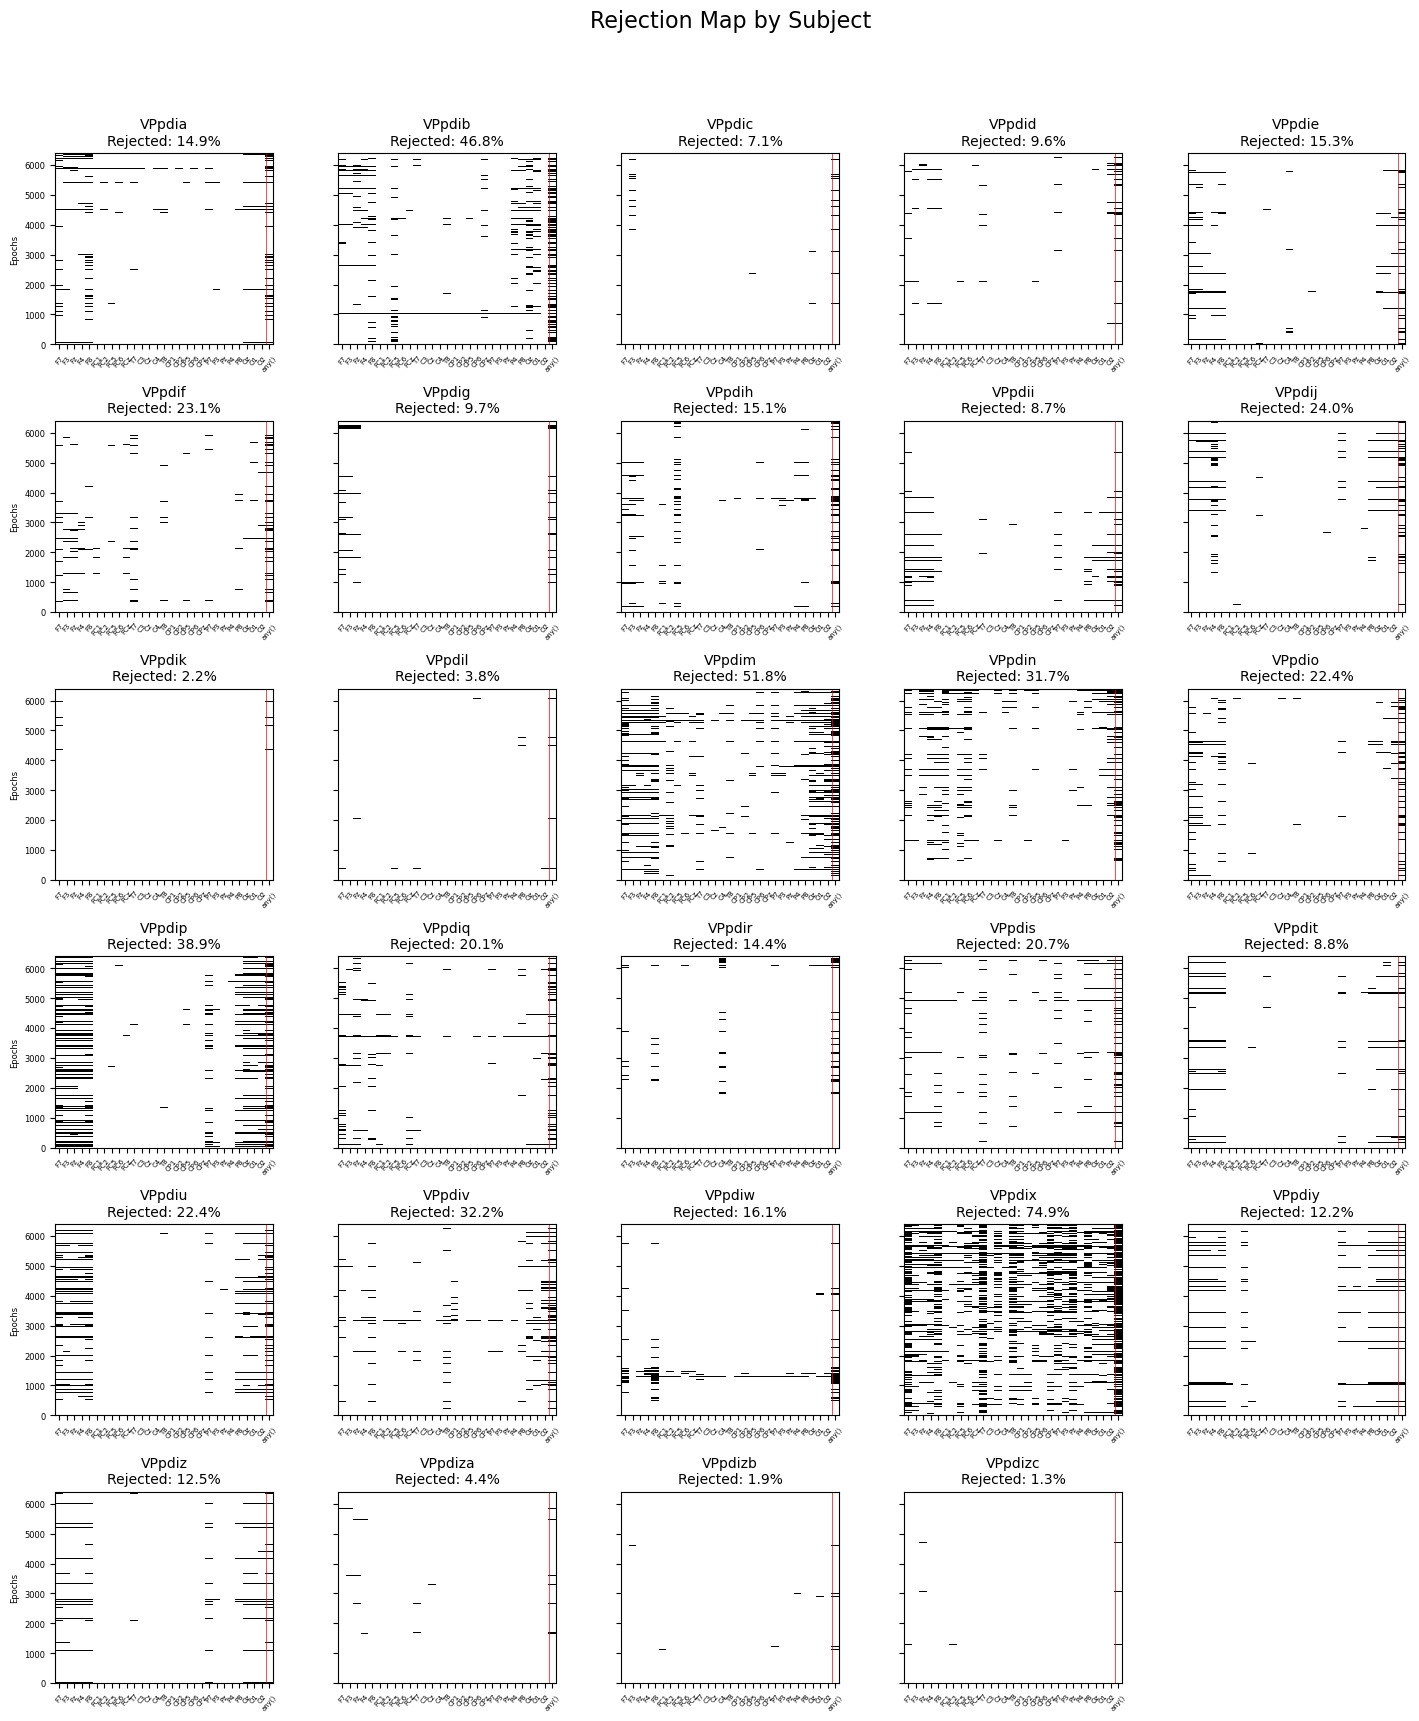

In [6]:
# Plot rejection map pf p300 dataset
subjects_channel_reject = {
    "VPpdib": ["CP2"],
    "VPpdih": ["C3"],
    "VPpdizb": ["Fz"],
    "VPpdizc": ["FC2"]
}


# Add "any()" to the channel names for the last column
picks_hubner_with_any = picks_hubner + ["any()"]

# Dynamic layout for the number of subjects
num_subjects = len(subjects)
max_columns = 5
cols = min(num_subjects, max_columns)  # Dynamically set the number of columns
rows = (num_subjects + cols - 1) // cols  # Calculate rows needed for grid layout

fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
fig.suptitle('Rejection Map by Subject', fontsize=16)

# Handle cases where the layout is 1D (rows or columns = 1)
if rows == 1:
    axes = [axes]
if cols == 1:
    axes = [[ax] for ax in axes]

# Plot heatmaps for each subject
for i, subject in enumerate(subjects):
    ax = axes[i // cols][i % cols]
    reject_subj = reject_percentages[i]
    rejection_matrix = subject_rejection_matrices.get(subject, np.zeros((0, len(picks_hubner_with_any))))

    # Exclude specified channels for this participant

    if subject in subjects_channel_reject:
        excluded_channel = subjects_channel_reject[subject]
        if excluded_channel in picks_hubner_with_any:
            idx = picks_hubner_with_any.index(excluded_channel)
            rejection_matrix = np.delete(rejection_matrix, idx, axis=1)  # Remove the column
            picks_hubner_with_any_filtered = [ch for ch in picks_hubner_with_any if ch != excluded_channel]
        else:
            picks_hubner_with_any_filtered = picks_hubner_with_any
    else:
        picks_hubner_with_any_filtered = picks_hubner_with_any

    # Plot heatmap for the subject
    heatmap = ax.imshow(rejection_matrix, aspect='auto', cmap='gray_r', interpolation='none')
    ax.set_title(f'{subject}\nRejected: {reject_subj * 100:.1f}%', fontsize=10)
    
    # Set x-axis labels with "any()" as the last label
    ax.set_xticks(range(len(picks_hubner_with_any_filtered)))
    ax.set_xticklabels(picks_hubner_with_any_filtered, rotation=50, fontsize=5)
    ax.vlines(len(picks_hubner) - 0.5, ymin=-0.5, ymax=rejection_matrix.shape[0] - 0.5, color='red', linewidth=0.5)
    
    # Set y-axis labels for the first column only and invert the y-axis
    if (i % cols) == 0:
        ax.set_yticks(range(0, 6401, 1000))
        ax.set_yticklabels(range(0, 6401, 1000), fontsize=6)
        ax.set_ylabel('Epochs', fontsize=6)
    else:
        ax.set_yticks(range(0, 6401, 1000))
        ax.set_yticklabels([])
    ax.invert_yaxis()  # Invert y-axis for consistent visualization

# Hide unused subplots, if any
for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

# Adjust spacing around and between subplots
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.3, hspace=0.4)

# Save the figure as an SVG file
save_path = os.path.join(raw_dir, "rejection_map_postrejection.svg")

fig.savefig(save_path, format='svg', dpi=500, bbox_inches="tight", pad_inches=0.1)  # Enhanced saving
